In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [196]:
df=pd.read_csv(r'garments_worker_productivity.csv')
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [197]:
# Feature baru untuk Target
df['productivity_status']=(df['actual_productivity']>=df['targeted_productivity']).astype(int)

df=df.drop(columns=['actual_productivity','targeted_productivity'])

Info datanya

1. date -> tanggal
2. quarter -> kuartal dalam sebulan
3. department -> Departemen kerja
4. day -> Hari
5. team -> Nomor tim
6. targeted_productivity -> target produktivitas harian
7. smv -> Standard Minute Value, waktu yang dialokasikan mengerjakan tugas
8. wip -> barang-barang yang sedang dikerjakan
9. over_time -> jumlah waktu lembur dalam menit
10. incentive -> bonus dalam mata uang BDT(Taka Bangladesh)
11. idle_time -> Waktu idle karena gangguan
12. idle_men -> jml pekerja yang menganggur
13. no_of_style_change -> Jumlah perubahan gaya produk
14. no_of_workers -> jumlah pekerja dalam tim
15. actual_productivity -> produktivitas yang telah dicapai

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1197 non-null   object 
 1   quarter              1197 non-null   object 
 2   department           1197 non-null   object 
 3   day                  1197 non-null   object 
 4   team                 1197 non-null   int64  
 5   smv                  1197 non-null   float64
 6   wip                  691 non-null    float64
 7   over_time            1197 non-null   int64  
 8   incentive            1197 non-null   int64  
 9   idle_time            1197 non-null   float64
 10  idle_men             1197 non-null   int64  
 11  no_of_style_change   1197 non-null   int64  
 12  no_of_workers        1197 non-null   float64
 13  productivity_status  1197 non-null   int32  
dtypes: float64(4), int32(1), int64(5), object(4)
memory usage: 126.4+ KB


In [199]:
y=df[df['incentive']<0]
y

,date,quarter,department,day,team,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_status


# Data Cleansing

In [200]:
#ubah type data
df['date']=pd.to_datetime(df['date'])
#handling extra space
df['department']=df['department'].str.strip()
#handling kesalahan penulisan
df['department']=df['department'].replace('sweing','sewing')

In [201]:
print('wip',506/1197)

wip 0.4227234753550543


In [202]:
# cek missing value
df.isnull().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
smv                      0
wip                    506
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
productivity_status      0
dtype: int64

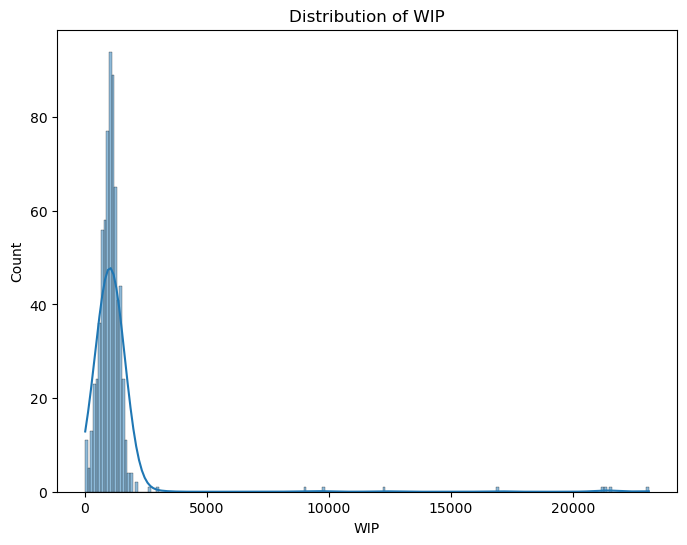

In [203]:
#distribusi wip
plt.figure(figsize=(8,6))
sns.histplot(df['wip'],kde=True)
plt.title('Distribution of WIP')
plt.xlabel('WIP')
plt.show()

In [204]:
#handling missing value
df['wip']=df['wip'].fillna(df['wip'].median())

In [205]:
#cek duplicate
df.duplicated().sum()

0

# Exploratory Data Analays

In [206]:
categoricals=['quarter','department','day']
numericals=['team','smv','wip','over_time','incentive','idle_time','idle_men','no_of_style_change','no_of_workers','productivity_status']
df[numericals].describe()

,team,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_status
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,15.062172,1126.437761,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.730994
std,3.463963,10.943219,1397.653191,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.443628
min,1.000000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,3.000000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000
50%,6.000000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1.000000
75%,9.000000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,1.000000
max,12.000000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000


In [207]:
df[categoricals].describe()

,quarter,department,day
count,1197,1197,1197
unique,5,2,6
top,Quarter1,sewing,Wednesday
freq,360,691,208


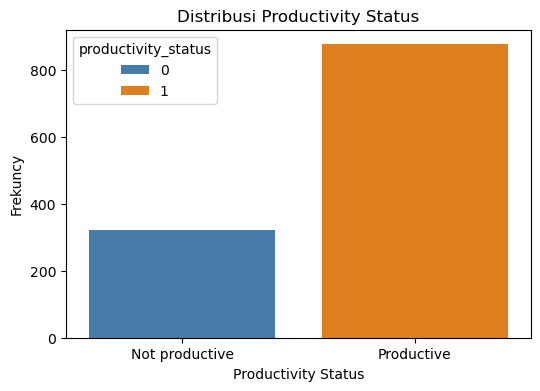

In [208]:
# Plot distribusi menggunakan bar plot
plt.figure(figsize=(6, 4))
custom_palette=['#377eb8', '#ff7f00']
sns.countplot(x='productivity_status', hue='productivity_status', data=df, palette=custom_palette)
plt.title('Distribusi Productivity Status')
plt.xlabel('Productivity Status')
plt.ylabel('Frekuncy')
plt.xticks([0, 1], ['Not productive', 'Productive'], rotation=0)
plt.show()


## Univariate Analysis

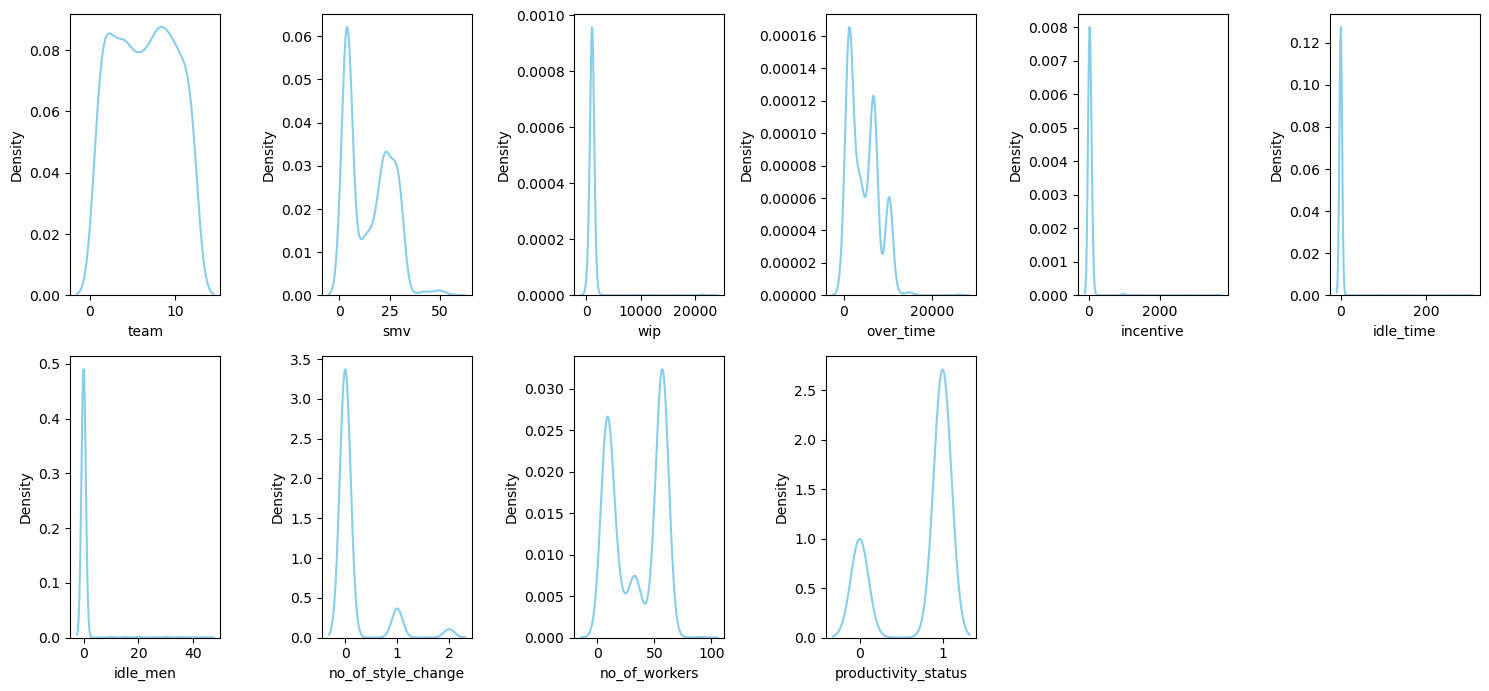

In [209]:
#distribusi for all distribution
plt.figure(figsize=(15,10))
for i in range(0,len(numericals)):
    plt.subplot(3, len(numericals)//2 +1, i+1)
    sns.kdeplot(x=df[numericals[i]], color='skyblue')
    plt.xlabel(numericals[i])
    plt.tight_layout()

## Bivariative Analysis

### Categorical Data

In [210]:
from matplotlib.patches import Patch
def categorical_data(title):
    custom_palette = ['#377eb8', '#ff7f00']  # Warna untuk legend
    
    # Buat catplot
    g = sns.catplot(
        x=title,
        kind='count',
        hue='productivity_status',
        palette=custom_palette,
        data=df,
        order=df[title].value_counts().index,
        hue_order=[0, 1],  # Urutan warna sesuai dengan status
        height=7,
        aspect=1.5,
        legend=False
    )
    
    # Ambil axis dari FacetGrid
    ax = g.ax

    # Tambahkan label angka di atas bar
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            p.get_height() + 1,
            '{0:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom',
            fontsize=10
        )

    # Buat custom legend
    legend_labels = ['Not Productive', 'Productive']
    legend_colors = [Patch(color=custom_palette[0], label=legend_labels[0]),
                     Patch(color=custom_palette[1], label=legend_labels[1])]
    ax.legend(handles=legend_colors, title='Productivity Status', loc='upper right')

    # Tambahkan judul plot
    plt.title(f'Count Plot of {title} by Productivity Status', fontsize=14, pad=20)
    


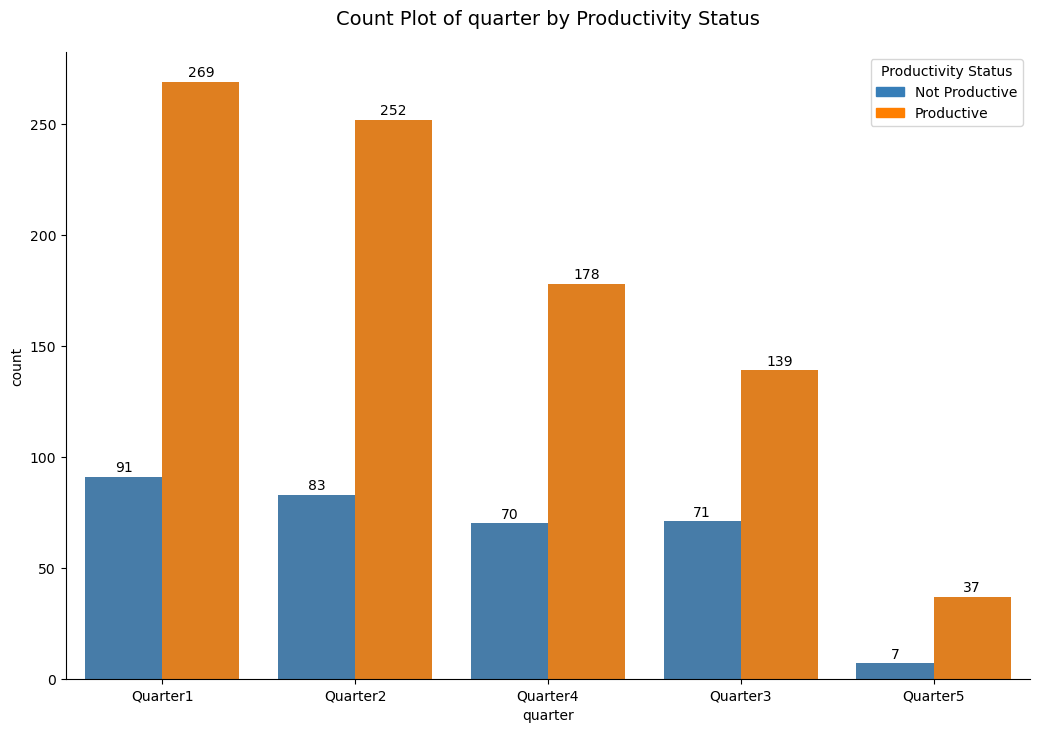

In [211]:
categorical_data('quarter')

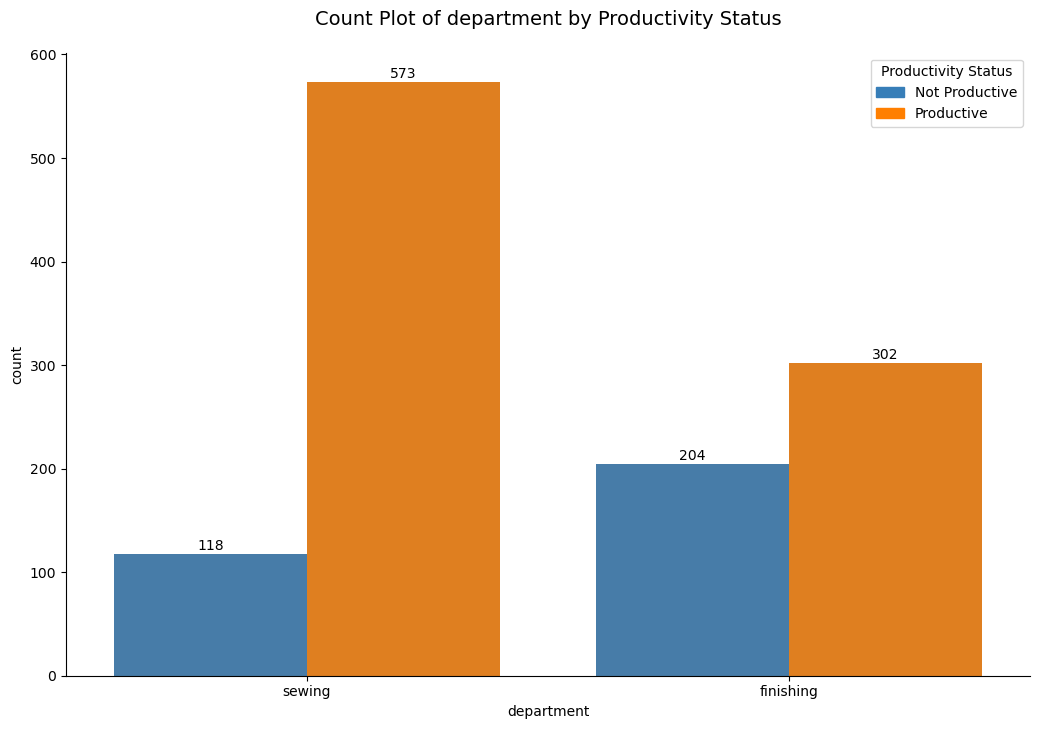

In [212]:
categorical_data('department')


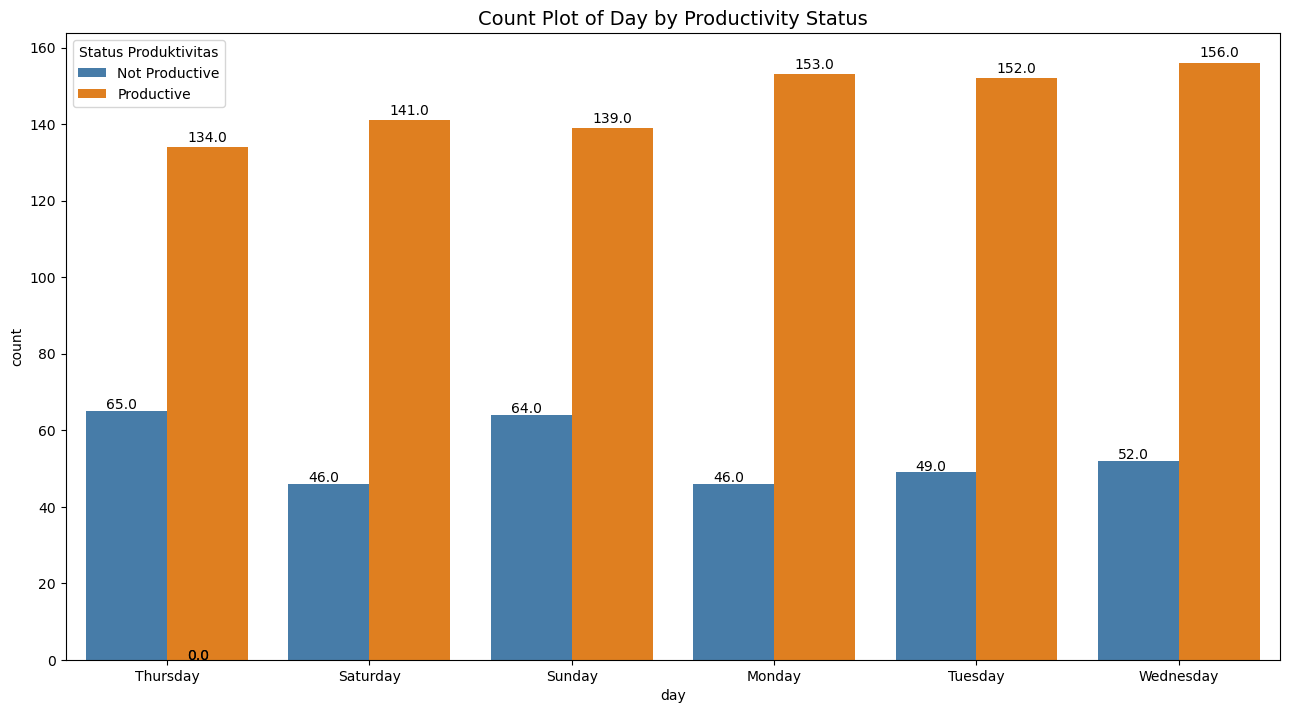

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Count Plot
plt.figure(figsize=(13,7))
custom_palette = ['#377eb8', '#ff7f00']

# Menggunakan hue_order untuk menentukan urutan dan mengganti label di legend
ax = sns.countplot(x='day', hue="productivity_status", palette=custom_palette, data=df, hue_order=[0, 1])

# Menambahkan anotasi pada setiap batang
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height() * 1.01))

# Mengubah label legend dari 0, 1 menjadi 'Produktif' dan 'Tidak Produktif'
handles, labels = ax.get_legend_handles_labels()
labels = ['Not Productive','Productive']  # Ganti label di sini
ax.legend(handles, labels, title='Status Produktivitas')

# Menambahkan layout dan judul
plt.tight_layout()
plt.title(f'Count Plot of Day by Productivity Status', fontsize=14)
plt.show()


### Numerical Data

In [214]:
def dist_bivariate(title):
    custom_palette=['#ff7f00','#377eb8']
    df_data=df.copy()
    df_data['productivity_status_label']=df_data['productivity_status'].replace({
        0:'Not Productive',
        1:'Productive'
    })
    g=sns.FacetGrid(
        df_data,
        hue='productivity_status_label',
        palette=custom_palette
    )
    g.map(sns.kdeplot, title, fill=True)
    g.add_legend()
    g.fig.suptitle(f'Distribution of {title} by Productivity Status', fontsize=12)
    g.fig.subplots_adjust(top=0.85)
    plt.show()

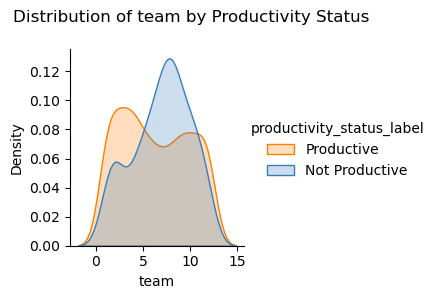

In [215]:
dist_bivariate('team')

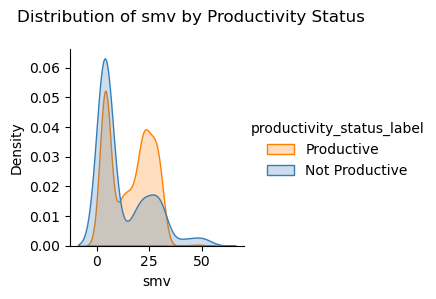

In [216]:
dist_bivariate('smv')

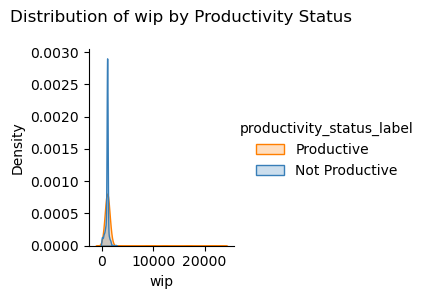

In [217]:
dist_bivariate('wip')

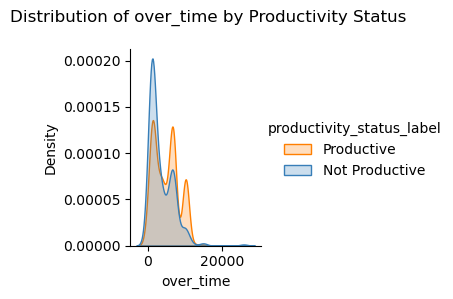

In [218]:
dist_bivariate('over_time')

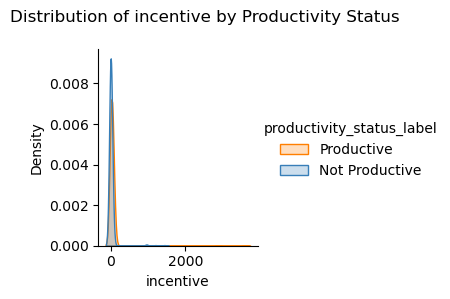

In [219]:
dist_bivariate('incentive')

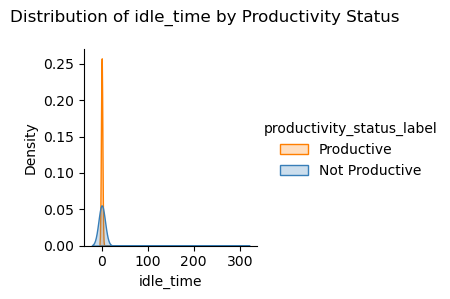

In [220]:
dist_bivariate('idle_time')

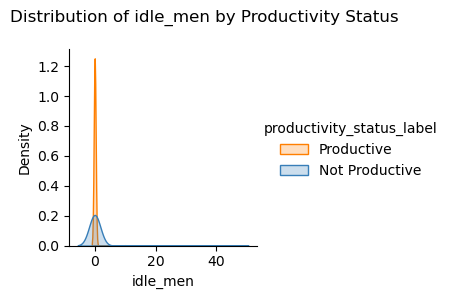

In [221]:
dist_bivariate('idle_men')

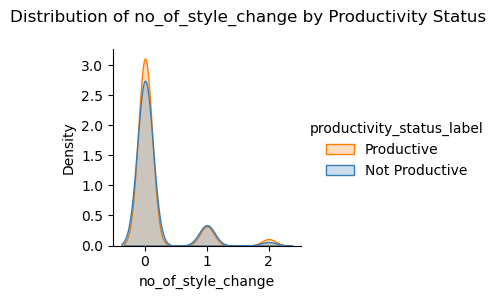

In [222]:
dist_bivariate('no_of_style_change')

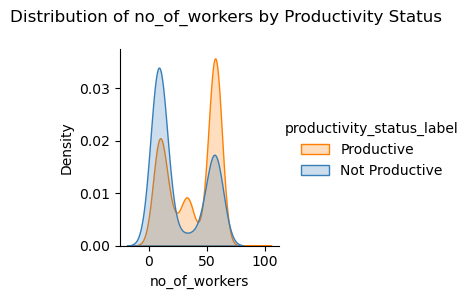

In [223]:
dist_bivariate('no_of_workers')

##  Multivariat Analysis

### Pengaruh jumlah pekerja

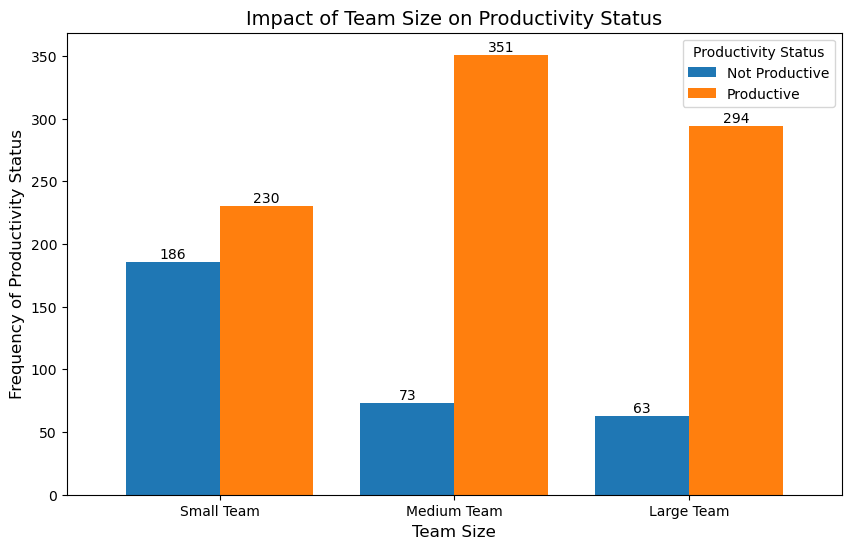

In [224]:
# Membagi jumlah pekerja menjadi kelompok
df['worker_group'] = pd.qcut(df['no_of_workers'], q=3, labels=['Small Team', 'Medium Team', 'Large Team'])

# Mengelompokkan data dengan label sementara
productivity_count = df.groupby(['worker_group', df['productivity_status'].replace({
    0: 'Not Productive',
    1: 'Productive'
})], observed=False).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = productivity_count.plot(kind='bar', ax=ax, width=0.8)

# Menambahkan label di diagram batang
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, color='black'
            )

# Judul, label, dan lainnya
plt.title('Impact of Team Size on Productivity Status', fontsize=14)
plt.xlabel('Team Size', fontsize=12)
plt.ylabel('Frequency of Productivity Status', fontsize=12)
plt.legend(title='Productivity Status')
plt.xticks(rotation=0)
plt.show()


Observasi:
- Kelompok dengan jumlah pekerja medium lebih banyak yang mencapai target
- Kelompok dengan jumlah pekerja sedikit paling banyak yang tidak mencapai target.

In [225]:
from scipy.stats import chi2_contingency

# Tabel kontingensi untuk Chi-Square dengan mengganti label dalam perhitungan
contingency_W = pd.crosstab(df['worker_group'], df['productivity_status'].replace({
    0: 'Not Productive',
    1: 'Productive'
}))
print(contingency_W)

# Uji Chi-Square
chi2, p, dof, expected = chi2_contingency(contingency_W)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f'Expected Frequencies:\n{expected}')

# Interpretasi
if p < 0.05:
    print("Terdapat hubungan signifikan antara Worker Group dan Productivity Status.")
else:
    print("Tidak terdapat hubungan signifikan antara Worker Group dan Productivity Status.")


productivity_status  Not Productive  Productive
worker_group                                   
Small Team                      186         230
Medium Team                      73         351
Large Team                       63         294
Chi-Square Statistic: 102.8755427043159
P-Value: 4.5799394920915525e-23
Degrees of Freedom: 2
Expected Frequencies:
[[111.90643275 304.09356725]
 [114.05847953 309.94152047]
 [ 96.03508772 260.96491228]]
Terdapat hubungan signifikan antara Worker Group dan Productivity Status.


Observasi:
- jumlah pekerja mempengaruhi produktivitas

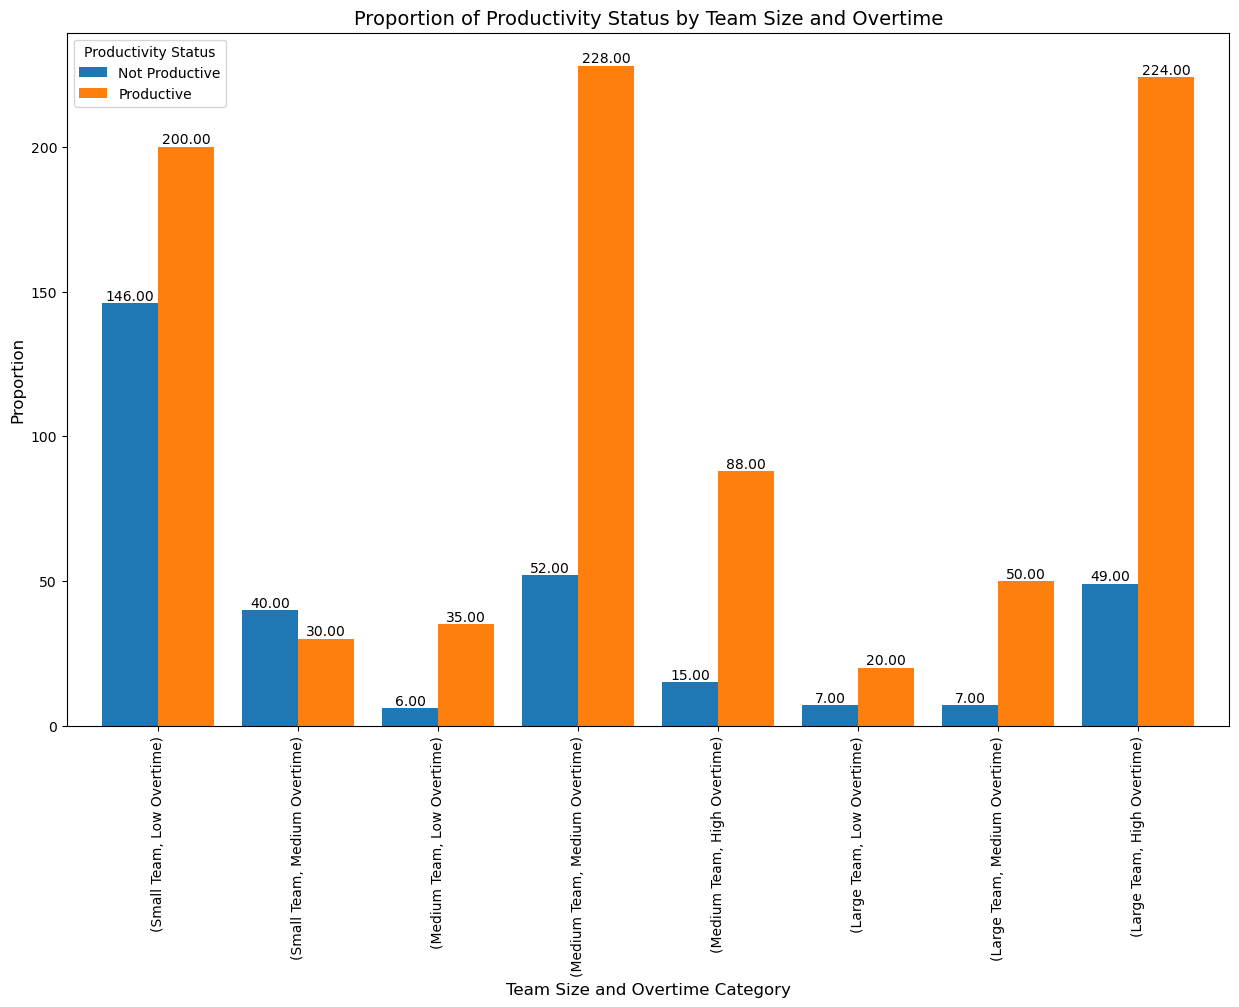

In [226]:
# Mengelompokkan overtime ke dalam tiga kategori
df['overtime_group'] = pd.qcut(df['over_time'], q=3, labels=['Low Overtime', 'Medium Overtime', 'High Overtime'])

# Mengelompokkan dan mengganti label 'productivity_status' secara langsung di dalam groupby dan value_counts
productivity_counts = df.groupby(['worker_group', 'overtime_group', 'productivity_status'], observed=False).size().unstack(fill_value=0)

# Menghapus baris yang totalnya 0
productivity_counts = productivity_counts.loc[productivity_counts.sum(axis=1) > 0]

# Plotting
ax = productivity_counts.plot(kind='bar', figsize=(15, 9), width=0.8)

# Label di diagram batang
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, color='black'
            )

# Judul, label, legend
plt.title('Proportion of Productivity Status by Team Size and Overtime', fontsize=14)
plt.xlabel('Team Size and Overtime Category', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Productivity Status', loc='upper left', labels=['Not Productive','Productive'])
plt.xticks(rotation=90)
plt.show()

observasi:
- Large team dengan medium overtime memiliki proporsi produktivitas tertinggi sebesar 88%
- team medium lebih baik produktifnya
- High overtime mempengaruhi produktivitas

In [227]:
from scipy.stats import chi2_contingency
import pandas as pd

# Menguji statistik produktivitas berdasarkan worker group dan overtime
contingency_WO = pd.crosstab(
    index=[df['worker_group'], df['overtime_group']], 
    columns=df['productivity_status'].replace({0: 'Tidak Produktif', 1: 'Produktif'})
)

# Melakukan uji Chi-Square
chi2_stat, p, dof, expected = chi2_contingency(contingency_WO)

# Tampilkan hasil uji Chi-Square
print(f'Chi2 Statistic: {chi2_stat}')
print(f'P-value: {p}')
print(f"Degrees of Freedom: {dof}")

# Menentukan signifikansi
if p < 0.05:
    print("Ada hubungan signifikan antara worker group, overtime, dan status produktivitas.")
else:
    print("Tidak ada hubungan signifikan antara ukuran tim, overtime, dan status produktivitas.")


Chi2 Statistic: 112.04739091042953
P-value: 3.451693273448525e-21
Degrees of Freedom: 7
Ada hubungan signifikan antara worker group, overtime, dan status produktivitas.


In [228]:
# Total data untuk Medium Team dan Large Team dengan High Overtime
for team_size, observed in [('Medium Team', [15, 88]), ('Large Team', [49, 224])]:
    total = sum(observed)
    expected = [total * 0.5, total * 0.5]  # Asumsikan distribusi 50-50

    # Uji Chi-Square
    chi2_stat, p_value, dof, expected = chi2_contingency([observed, expected])

    # Cetak hasil
    print(f"\nHasil Uji Chi-Square untuk {team_size} (High Overtime):")
    print(f"Chi2 Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected Distribution:\n{expected}")

    # Interpretasi
    if p_value < 0.05:
        print("Hasil signifikan: High Overtime memengaruhi produktivitas secara signifikan.")
    else:
        print("Hasil tidak signifikan: Tidak ada pengaruh signifikan.")



Hasil Uji Chi-Square untuk Medium Team (High Overtime):
Chi2 Statistic: 27.985177998760342
P-value: 1.2224823889504056e-07
Degrees of Freedom: 1
Expected Distribution:
[[33.25 69.75]
 [33.25 69.75]]
Hasil signifikan: High Overtime memengaruhi produktivitas secara signifikan.

Hasil Uji Chi-Square untuk Large Team (High Overtime):
Chi2 Statistic: 61.09078062439484
P-value: 5.450277152242731e-15
Degrees of Freedom: 1
Expected Distribution:
[[ 92.75 180.25]
 [ 92.75 180.25]]
Hasil signifikan: High Overtime memengaruhi produktivitas secara signifikan.


### Pengaruh Overtime

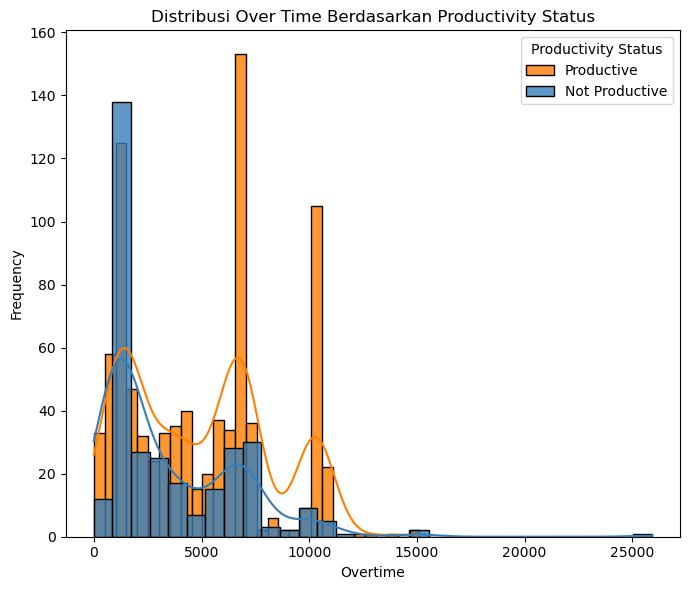

In [229]:
plt.figure(figsize=(7,6))
custom_palette = {
    'Productive': '#ff7f00',        
    'Not Productive': '#377eb8'   
}

# Plot untuk 'Productive' dan 'Not Productive' langsung tanpa membuat variabel baru
sns.histplot(df[df['productivity_status'] == 1]['over_time'], kde=True, color='#ff7f00', label='Productive', bins=30, alpha=0.8)
sns.histplot(df[df['productivity_status'] == 0]['over_time'], kde=True, color='#377eb8', label='Not Productive', bins=30, alpha=0.8)

plt.title('Distribusi Over Time Berdasarkan Productivity Status')
plt.xlabel('Overtime')
plt.ylabel('Frequency')
plt.legend(title='Productivity Status')
plt.tight_layout()
plt.show()

- Sebagian besar waktu lembur meningkatkan produktivitas terutama pada lembur rendah hingga 5000 menit.
- Semakin tinggi overtime lebih banyak yang produktif

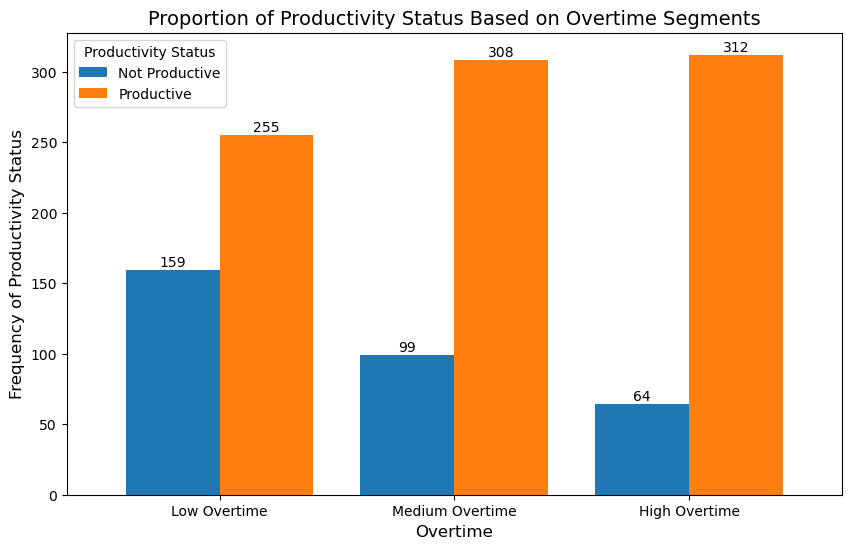

In [230]:
# Menggrupkan berdasarkan overtime_group dan productivity_status (misal 1 untuk Productive, 0 untuk Not Productive)
productivity_overtime = df.groupby(['overtime_group', 'productivity_status'], observed=False).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = productivity_overtime.plot(kind='bar', ax=ax, width=0.8)

# Label di diagram batang
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, color='black'
            )

# Judul, label
plt.title('Proportion of Productivity Status Based on Overtime Segments', fontsize=14)
plt.xlabel('Overtime', fontsize=12)
plt.ylabel('Frequency of Productivity Status', fontsize=12)
plt.legend(title='Productivity Status', labels=['Not Productive','Productive'])
plt.xticks(rotation=0)
plt.show()


Observasi:
- High overtime yang paling mempengaruhi produktivitas
- Overtime yang Medium dengan large memiliki perbedaan yang tidak begitu jauh, walaupun overtime yang panjang yang tidak mencapai target paling sedikit

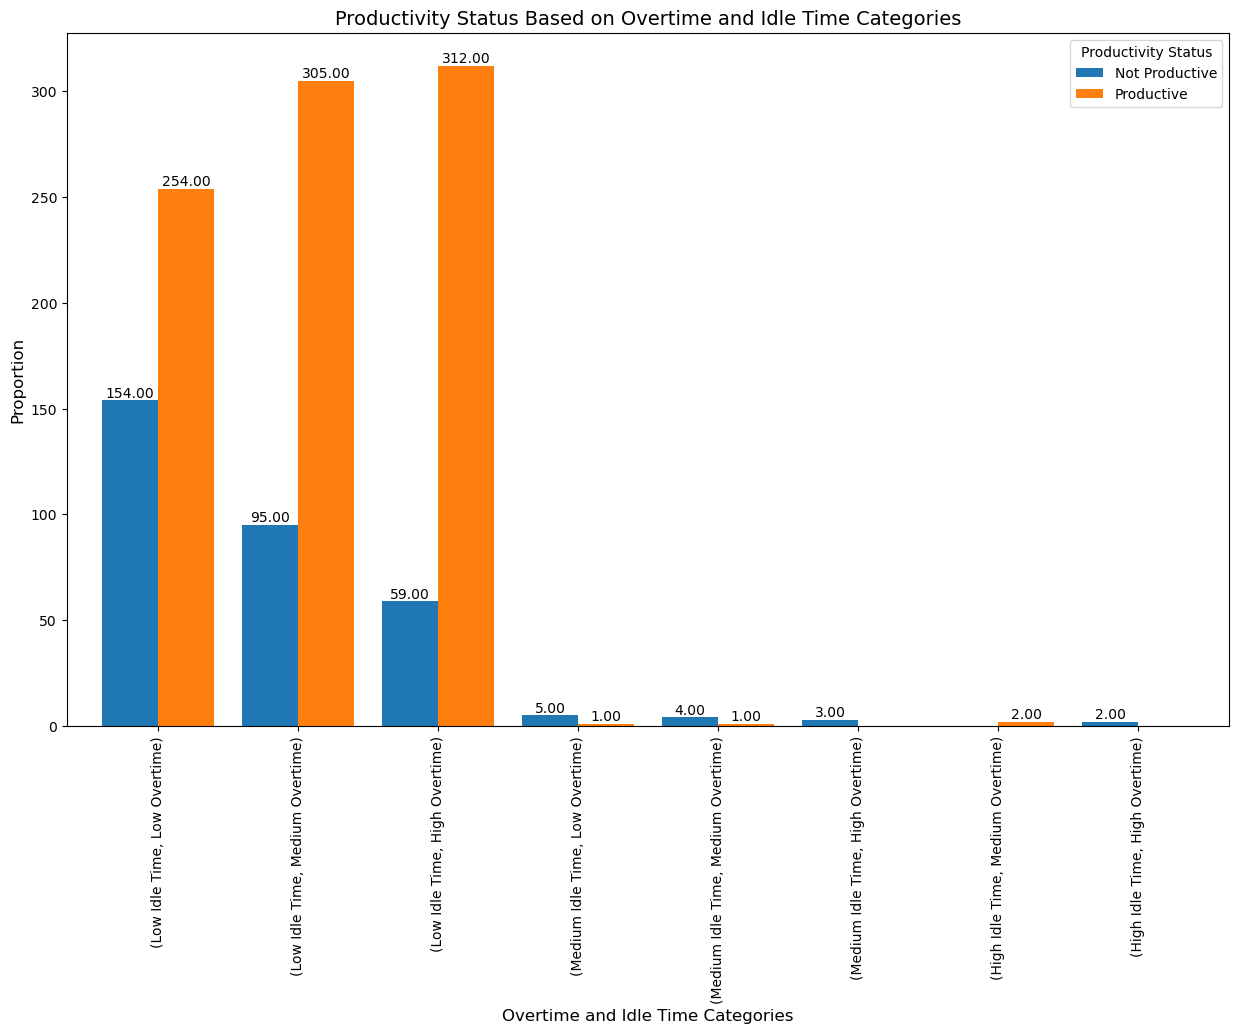

In [231]:
# Mengelompokkan idle time ke dalam tiga kategori
df['idle_time_group'] = pd.cut(df['idle_time'], bins=[-1, 1, 50, float('inf')], 
                                labels=['Low Idle Time', 'Medium Idle Time', 'High Idle Time'])

# Mengelompokkan dan menghitung frekuensi berdasarkan idle_time_group, overtime_group, dan productivity_status
productivity_ovtime_idltime = df.groupby(['idle_time_group', 'overtime_group', 'productivity_status'], observed=False).size().unstack(fill_value=0)

# Menghapus baris yang totalnya 0
productivity_ovtime_idltime = productivity_ovtime_idltime.loc[productivity_ovtime_idltime.sum(axis=1) > 0]

# Plot
ax = productivity_ovtime_idltime.plot(kind='bar', figsize=(15, 9), width=0.8)

# Label di diagram batang
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10, color='black'
            )

# Judul, label, legend
plt.title('Productivity Status Based on Overtime and Idle Time Categories', fontsize=14)
plt.xlabel('Overtime and Idle Time Categories', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.legend(title='Productivity Status', labels=['Not Productive','Productive'], loc='upper right')
plt.xticks(rotation=90)
plt.show()


Observasi:
- membagi idle time manjadi 3 yaitu low (0-1 menit), medium (1-50 menit), high (>=50)
- Idle time yang tinggi secara signifikan menurunkan produktivitas. 

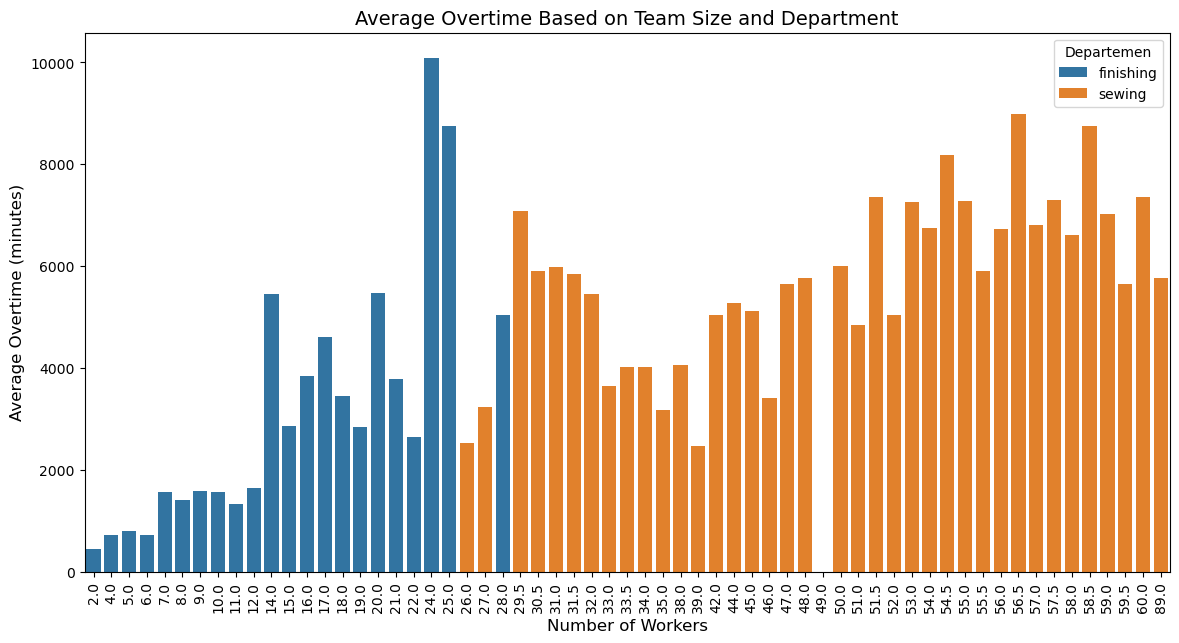

In [232]:
average_overtime = df.groupby(['department', 'no_of_workers'])['over_time'].mean().reset_index()
# Visualisasi menggunakan grafik batang
plt.figure(figsize=(14, 7))
sns.barplot(data=average_overtime, x='no_of_workers', y='over_time', hue='department')
plt.title('Average Overtime Based on Team Size and Department', fontsize=14)
plt.xlabel('Number of Workers',fontsize=12)
plt.ylabel('Average Overtime (minutes)',fontsize=12)
plt.legend(title='Departemen')
plt.xticks(rotation=90)
plt.show()

-  finishing rata-rata mengalami waktu lembur lebih lama dibanding sewing terutama di ukuran tim 14-25 pekerja.
- overtime meningkat seiring dengan bertambahnya ukuran tim, terutama di departemen sewing.

### Pengaruh IDle men dan IDLe time

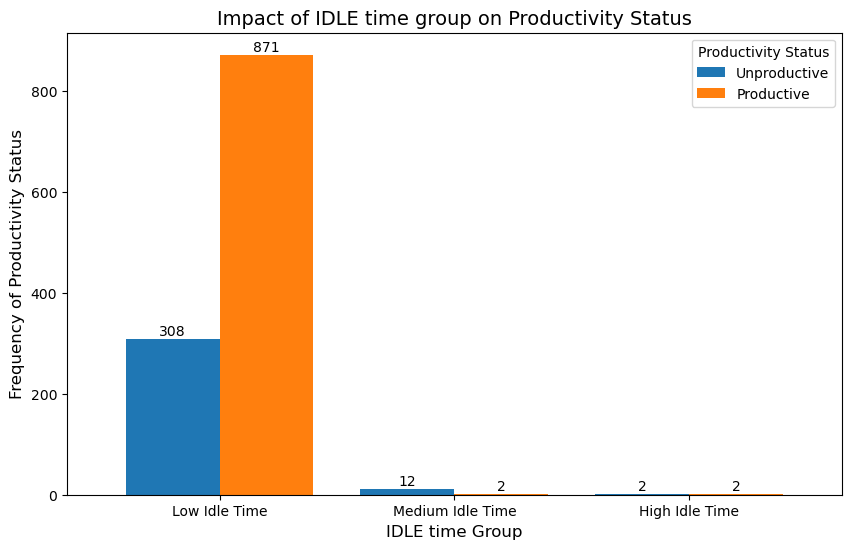

In [233]:
# Mengelompokkan berdasarkan idle_time_group dan status produktivitas
productivity_idltime = df.groupby(['idle_time_group', 'productivity_status'], observed=False).size().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = productivity_idltime.plot(kind='bar', ax=ax, width=0.8)

# Menambahkan label di diagram batang
for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, color='black'
            )

# Judul, label
plt.title('Impact of IDLE time group on Productivity Status', fontsize=14)
plt.xlabel('IDLE time Group', fontsize=12)
plt.ylabel('Frequency of Productivity Status', fontsize=12)
plt.legend(title='Productivity Status', labels=['Unproductive','Productive'])
plt.xticks(rotation=0)
plt.show()


Observasi:
- Idle men yang tinggi secara signifikan mengurangi kemungkinan pekerja mencapai status produktif.
- low idle men memiliki proporsi produktif lebih banyak
- semakin sedikit idle men sangat bagus untuk produktivitas pekerja

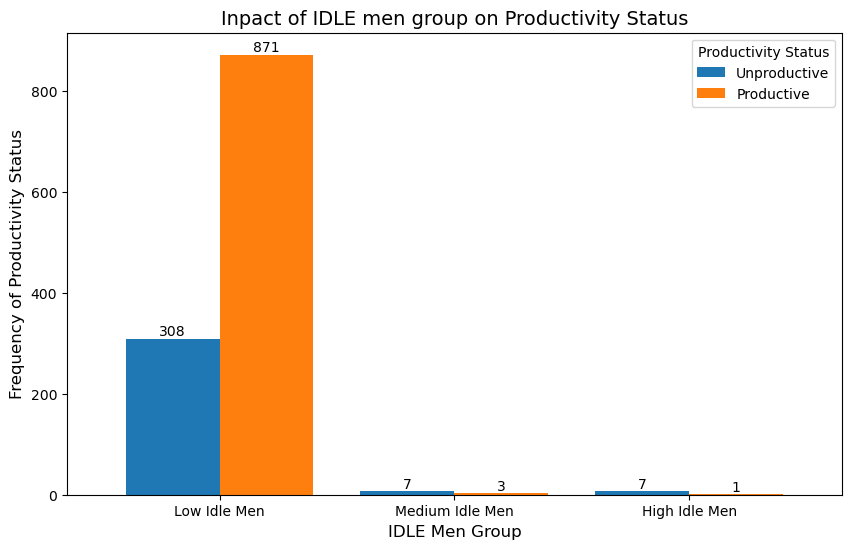

In [234]:
#membagi idle men
# Mengelompokkan idle time ke dalam tiga kategori
df['idle_men_group'] = pd.cut(df['idle_men'], bins=[-1, 0, 25, float('inf')], 
                                labels=['Low Idle Men', 'Medium Idle Men', 'High Idle Men'])

#menggrupkan
productivity_idlmen=df.groupby(['idle_men_group','productivity_status'], observed=False).size().unstack(fill_value=0)

#plot
fig,ax=plt.subplots(figsize=(10,6))
bars=productivity_idlmen.plot(kind='bar', ax=ax, width=0.8)
    
#label di diagram batang
for container in bars.containers:
    for bar in container:
        height=bar.get_height()
        if height>0:
            ax.text(
                bar.get_x()+bar.get_width()/2,
                height+0.5,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, color='black'
                )
# Judul, label
plt.title('Inpact of IDLE men group on Productivity Status',fontsize=14)
plt.xlabel('IDLE Men Group',fontsize=12)
plt.ylabel('Frequency of Productivity Status',fontsize=12)
plt.legend(title='Productivity Status', labels=['Unproductive','Productive'])
plt.xticks(rotation=0)
plt.show()

Observasi:
-  membagi idle men manjadi 3 yaitu low (0-9 org), medium (10-25 org), high (>=25 org)
- low idle time memiliki proporsi produktif lebih banyak
- semakin sedikit idle time sangat bagus untuk produktivitas pekerja
-  Idle time yang tinggi secara signifikan mengurangi kemungkinan pekerja mencapai status produktif.

Observasi:

- Idle Men Rendah --> Insentif berperan besar dalam meningkatkan produktivitas, dan semakin tinggi insentif, semakin besar peluang untuk mencapai target.
- Idle Men Sedang-->Insentif yang lebih tinggi tidak selalu berarti produktivitas tercapai, karena idle men sedang tetap menjadi penghambat yang signifikan.
- Idle Men Tinggi-->Insentif masih dapat memotivasi tim untuk mencapai produktivitas meskipun idle men tinggi, namun dampaknya terbatas dan insentif saja tidak cukup untuk mengatasi idle men yang tinggi.

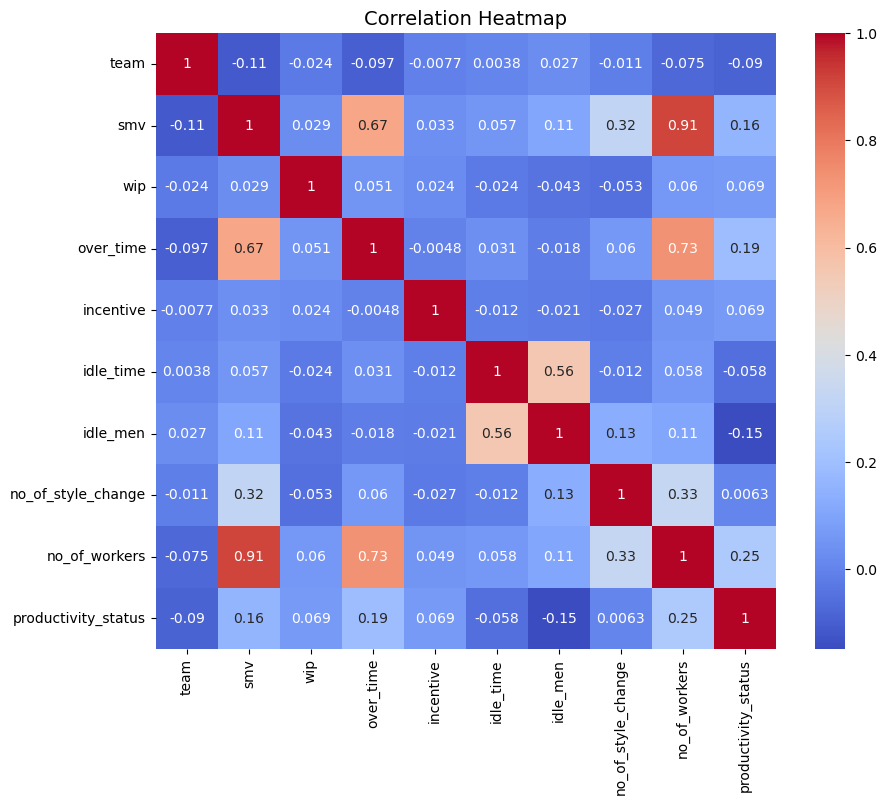

In [235]:
# heatmap correlations
correlation=df[numericals].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

# Feature Engineering

In [236]:
data_fe=df.copy()

In [237]:

from sklearn.model_selection import train_test_split

train, test =train_test_split(data_fe, test_size=0.2, random_state=42)

In [238]:
# Kolom target
target_column = 'productivity_status'

In [239]:
# Menghapus kolom yang tidak diperlukan dari train dan test
drop_columns = ['date', 'idle_time', 'no_of_workers', 'idle_men','overtime_group']
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

## Outlier

In [240]:
#check outlier
outlier_count={}
numericals = train.select_dtypes(include=['float64', 'int64']).columns
for column in numericals:
  q1=train[column].quantile(0.25)
  q3=train[column].quantile(0.75)
  iqr=q3-q1
  lower_bound=q1-1.5*iqr
  upper_bound=q3+1.5*iqr
  outlier=train[(train[column]<lower_bound)|(train[column]>upper_bound)]
  outlier_count[column] = outlier.shape[0]

for column, count in outlier_count.items():
  print(f'Outlier in {column}:{count}')

Outlier in team:0
Outlier in smv:0
Outlier in wip:298
Outlier in over_time:2
Outlier in incentive:10
Outlier in no_of_style_change:124


In [241]:
#handling outlier dengan capping
for column in numericals:
    q1=train[column].quantile(0.25)
    q3=train[column].quantile(0.75)
    iqr=q3-q1

    lower_bound=q1-1.5*iqr
    upper_bound=q3+1.5*iqr

    train[column]=train[column].apply(
        lambda x:lower_bound if x < lower_bound else upper_bound if x> upper_bound else x
    )

In [242]:
p=train[train['incentive']<0]
print(p)

Empty DataFrame
Columns: [quarter, department, day, team, smv, wip, over_time, incentive, no_of_style_change, productivity_status, worker_group, idle_time_group, idle_men_group]
Index: []


In [243]:
zero_counts = train.eq(0).sum()
print(zero_counts)

quarter                  0
department               0
day                      0
team                     0
smv                      0
wip                      0
over_time               23
incentive              487
no_of_style_change     957
productivity_status    259
worker_group             0
idle_time_group          0
idle_men_group           0
dtype: int64


In [244]:
zero_test = test.eq(0).sum()
print(zero_test)

quarter                  0
department               0
day                      0
team                     0
smv                      0
wip                      0
over_time                8
incentive              117
no_of_style_change     217
productivity_status     63
worker_group             0
idle_time_group          0
idle_men_group           0
dtype: int64


In [245]:
# Ganti nilai nol atau negatif dengan median kolom 'incentive'
median_incentive = train[train['incentive'] > 0]['incentive'].median()
median_wip=train[train['wip']>0]['wip'].median()
# median_idletime=train[train['idle_time']>0]['idle_time'].median()
# median_idlemen=train[train['idle_men']>0]['idle_men'].median()
#rain
train['incentive'] = train['incentive'].apply(lambda x: x if x > 0 else median_incentive)
train['wip'] = train['wip'].apply(lambda x: x if x > 0 else median_wip)
# train['idle_time'] = train['idle_time'].apply(lambda x: x if x > 0 else median_idletime)
# train['idle_men'] = train['idle_men'].apply(lambda x: x if x > 0 else median_idlemen)

#test
test['incentive'] = test['incentive'].apply(lambda x: x if x > 0 else median_incentive)
test['wip'] = test['wip'].apply(lambda x: x if x > 0 else median_wip)
# test['idle_time'] = test['idle_time'].apply(lambda x: x if x > 0 else median_idletime)
# test['idle_men'] = test['idle_men'].apply(lambda x: x if x > 0 else median_idlemen)

# Tranform train
train['incentive'] = np.log10(train['incentive'])
train['wip']=np.log10(train['wip'])
# train['idle_time']=np.log10(train['idle_time'])
# train['idle_men']=np.log10(train['idle_men'])

#transform test
test['incentive'] = np.log10(test['incentive'])
test['wip']=np.log10(test['wip'])
# test['idle_time']=np.log10(test['idle_time'])
# test['idle_men']=np.log10(test['idle_men'])

In [246]:
train.head()

,quarter,department,day,team,smv,wip,over_time,incentive,no_of_style_change,productivity_status,worker_group,idle_time_group,idle_men_group
1189,Quarter2,sewing,Wednesday,8,30.48,2.960946,6840.0,1.477121,0.0,1,Large Team,Low Idle Time,Low Idle Men
575,Quarter1,finishing,Monday,1,3.94,3.016616,2280.0,1.698970,0.0,0,Medium Team,Low Idle Time,Low Idle Men
76,Quarter1,finishing,Monday,10,2.90,3.016616,960.0,1.698970,0.0,1,Small Team,Low Idle Time,Low Idle Men
731,Quarter2,finishing,Thursday,4,4.15,3.016616,1800.0,1.698970,0.0,1,Medium Team,Low Idle Time,Low Idle Men
138,Quarter2,sewing,Thursday,12,11.61,2.909021,15090.0,1.799341,0.0,1,Medium Team,Low Idle Time,Low Idle Men


## Encoding

In [247]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 957 entries, 1189 to 1126
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   quarter              957 non-null    object  
 1   department           957 non-null    object  
 2   day                  957 non-null    object  
 3   team                 957 non-null    int64   
 4   smv                  957 non-null    float64 
 5   wip                  957 non-null    float64 
 6   over_time            957 non-null    float64 
 7   incentive            957 non-null    float64 
 8   no_of_style_change   957 non-null    float64 
 9   productivity_status  957 non-null    int32   
 10  worker_group         957 non-null    category
 11  idle_time_group      957 non-null    category
 12  idle_men_group       957 non-null    category
dtypes: category(3), float64(5), int32(1), int64(1), object(3)
memory usage: 81.7+ KB


In [248]:
from sklearn.preprocessing import OrdinalEncoder
for col in categoricals:
  data_fe[col]=data_fe[col].astype(str)
# One-Hot Encoding untuk department dan day
train = pd.get_dummies(train, columns=['department', 'day'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['department', 'day'], drop_first=True, dtype=int)


# Ordinal Encoding untuk quarter
ordinal_encoder = OrdinalEncoder(categories=[['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']])
train['quarter_encoded'] = ordinal_encoder.fit_transform(train[['quarter']])
test['quarter_encoded'] = ordinal_encoder.transform(test[['quarter']])

#Ordinal encoding untuk woker group
ordinal_encoder= OrdinalEncoder(categories=[['Small Team','Medium Team','Large Team']])
train['worker_group_encoded']=ordinal_encoder.fit_transform(train[['worker_group']])
test['worker_group_encoded']=ordinal_encoder.transform(test[['worker_group']])

#Ordinal encoding untuk idle_time_group 
ordinal_encoder_idletime= OrdinalEncoder(categories=[['Low Idle Time', 'Medium Idle Time', 'High Idle Time']])
train['idletime_group_encoded']=ordinal_encoder_idletime.fit_transform(train[['idle_time_group']])
test['idletime_group_encoded']=ordinal_encoder_idletime.transform(test[['idle_time_group']])

#Ordinal encoding untuk idle_men_group 
ordinal_encoder_idlemen= OrdinalEncoder(categories=[['Low Idle Men', 'Medium Idle Men', 'High Idle Men']])
train['idlemen_group_encoded']=ordinal_encoder_idlemen.fit_transform(train[['idle_men_group']])
test['idlemen_group_encoded']=ordinal_encoder_idlemen.transform(test[['idle_men_group']])

#drop kolumn

train=train.drop(columns=['quarter','worker_group', 'idle_time_group','idle_men_group'])

test=test.drop(columns=['quarter','worker_group', 'idle_time_group','idle_men_group'])

- Sudah buat overtime_group tapi tidak mempengaruhi overtime

In [249]:
# Pastikan tidak ada nilai negatif atau nol pada kolom 'incentive' sebelum log transformasi
if (train['incentive'] <= 0).any():
    print("Warning: Kolom 'incentive' mengandung nilai nol atau negatif.")

In [250]:
# Cek NaN pada data setelah preprocessing
if train.isnull().any().any():
    print("Warning: Terdapat nilai NaN di dalam data.")

## Scalling

In [251]:
#feature scalling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
columns_to_scale = ['smv', 'wip', 'incentive', 'no_of_style_change']
# Scale the numerical features only on the training data
# numerical_features= feature_train.select_dtypes(include=['int64', 'float64']).columns

#fit the scalaar on the training
train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
# Apply the same scaler to the test data (use transform, not fit_transform)
test[columns_to_scale] = scaler.transform(test[columns_to_scale])

## Split into Xtrain,ytrain,Xtest,ytest

In [252]:
# Memisahkan target dari fitur setelah scaling
ytrain = train[target_column]
Xtrain = train.drop(columns=[target_column])

ytest = test[target_column]
Xtest = test.drop(columns=[target_column])

print('There are {} samples in the training set and {} samples in the test set.'.format(
    Xtrain.shape[0], Xtest.shape[0]))
print()

There are 957 samples in the training set and 240 samples in the test set.



# Modeling

In [253]:
#Membangun model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
models={
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True,class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(force_col_wise=True)

}

## Model terbaik menggunakan smote

In [254]:
from sklearn.metrics import recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE

# Fungsi untuk menghitung dan menampilkan metrik
def evaluate_models(Xtrain, ytrain, Xtest, ytest, use_smote=False):
    results = {}
    
    # Menerapkan SMOTE jika dibutuhkan
    if use_smote:
        smote = SMOTE(k_neighbors=1,random_state=42)
        Xtrain, ytrain = smote.fit_resample(Xtrain, ytrain)

    # Melatih dan mengevaluasi setiap model
    for model_name, model in models.items():
        print(f"Model: {model_name}")

        # Melatih model dengan data pelatihan
        model.fit(Xtrain, ytrain)
        
        # Prediksi untuk data pelatihan dan pengujian
        ytrain_pred = model.predict(Xtrain)
        ytest_pred = model.predict(Xtest)
        
        # Menghitung metrik untuk train dataset
        # train_accuracy = accuracy_score(ytrain, ytrain_pred)
        train_recall = recall_score(ytrain, ytrain_pred, average='weighted')
        train_precision = precision_score(ytrain, ytrain_pred, average='weighted')
        train_f1 = f1_score(ytrain, ytrain_pred, average='weighted')
        # train_roc_auc = roc_auc_score(ytrain, model.predict_proba(Xtrain), multi_class='ovr', average='weighted')
        
        # Menghitung metrik untuk test dataset
        # test_accuracy = accuracy_score(ytest, ytest_pred)
        test_recall = recall_score(ytest, ytest_pred, average='weighted')
        test_precision = precision_score(ytest, ytest_pred, average='weighted')
        test_f1 = f1_score(ytest, ytest_pred, average='weighted')
        # test_roc_auc = roc_auc_score(ytest, model.predict_proba(Xtest), multi_class='ovr', average='weighted')

        # Menampilkan hasil metrik untuk train dan test
        print(f"Train Metrics:")
        # print(f"  Accuracy: {train_accuracy:.4f}")
        print(f"  Recall: {train_recall:.4f}")
        print(f"  Precision: {train_precision:.4f}")
        print(f"  F1-Score: {train_f1:.4f}")
        # print(f"  ROC-AUC: {train_roc_auc:.4f}")
        
        print(f"Test Metrics:")
        # print(f"  Accuracy: {test_accuracy:.4f}")
        print(f"  Recall: {test_recall:.4f}")
        print(f"  Precision: {test_precision:.4f}")
        print(f"  F1-Score: {test_f1:.4f}")
        # print(f"  ROC-AUC: {test_roc_auc:.4f}")
        print()
        
        # Menyimpan hasil F1 score untuk dibandingkan antar model
        results[model_name] = {
            'train_recall': train_recall,
            'train_precision': train_precision,
            'train_f1': train_f1,
            'test_recall': test_recall,
            'test_precision': test_precision,
            'test_f1': test_f1
        }
    
    return results

# Menjalankan evaluasi model dengan SMOTE
results = evaluate_models(Xtrain, ytrain, Xtest, ytest, use_smote=True)

Model: Logistic Regression
Train Metrics:
  Recall: 0.7264
  Precision: 0.7264
  F1-Score: 0.7264
Test Metrics:
  Recall: 0.6667
  Precision: 0.6905
  F1-Score: 0.6765

Model: Random Forest
Train Metrics:
  Recall: 0.9979
  Precision: 0.9979
  F1-Score: 0.9979
Test Metrics:
  Recall: 0.7917
  Precision: 0.7842
  F1-Score: 0.7869

Model: Decision Tree
Train Metrics:
  Recall: 0.9979
  Precision: 0.9979
  F1-Score: 0.9979
Test Metrics:
  Recall: 0.7292
  Precision: 0.7363
  F1-Score: 0.7324

Model: Gradient Boosting
Train Metrics:
  Recall: 0.8883
  Precision: 0.8883
  F1-Score: 0.8882
Test Metrics:
  Recall: 0.7625
  Precision: 0.7567
  F1-Score: 0.7592

Model: Support Vector Machine
Train Metrics:
  Recall: 0.6117
  Precision: 0.6121
  F1-Score: 0.6115
Test Metrics:
  Recall: 0.6167
  Precision: 0.6878
  F1-Score: 0.6380

Model: K-Nearest Neighbors
Train Metrics:
  Recall: 0.8553
  Precision: 0.8608
  F1-Score: 0.8547
Test Metrics:
  Recall: 0.6542
  Precision: 0.7095
  F1-Score: 0.671

## Model terbaik tanpa smote

In [255]:
# Evaluate models without SMOTE
print("Evaluating models without SMOTE:")
results_without_smote = evaluate_models(Xtrain, ytrain, Xtest, ytest, use_smote=False)

Evaluating models without SMOTE:
Model: Logistic Regression
Train Metrics:
  Recall: 0.7471
  Precision: 0.7171
  F1-Score: 0.7062
Test Metrics:
  Recall: 0.7667
  Precision: 0.7475
  F1-Score: 0.7207

Model: Random Forest
Train Metrics:
  Recall: 0.9979
  Precision: 0.9979
  F1-Score: 0.9979
Test Metrics:
  Recall: 0.8292
  Precision: 0.8213
  F1-Score: 0.8198

Model: Decision Tree
Train Metrics:
  Recall: 0.9979
  Precision: 0.9979
  F1-Score: 0.9979
Test Metrics:
  Recall: 0.7125
  Precision: 0.7261
  F1-Score: 0.7183

Model: Gradient Boosting
Train Metrics:
  Recall: 0.8683
  Precision: 0.8687
  F1-Score: 0.8599
Test Metrics:
  Recall: 0.8333
  Precision: 0.8287
  F1-Score: 0.8190

Model: Support Vector Machine
Train Metrics:
  Recall: 0.6050
  Precision: 0.7003
  F1-Score: 0.6270
Test Metrics:
  Recall: 0.6167
  Precision: 0.6878
  F1-Score: 0.6380

Model: K-Nearest Neighbors
Train Metrics:
  Recall: 0.8359
  Precision: 0.8304
  F1-Score: 0.8259
Test Metrics:
  Recall: 0.7625
  Pr

## Model terbaiknya

In [256]:
# Membuat DataFrame untuk menyimpan hasil perbandingan antara dengan SMOTE dan tanpa SMOTE
comparison_results = []

# Menambahkan hasil dari evaluasi dengan SMOTE ke dalam comparison_results
for model_name in results:
    comparison_results.append({
        'Model': model_name,
        'Train Recall (SMOTE)': results[model_name]['train_recall'],
        'Test Recall (SMOTE)': results[model_name]['test_recall'],
        'Train Precision (SMOTE)': results[model_name]['train_precision'],
        'Test Precision (SMOTE)': results[model_name]['test_precision'],
        'Train F1 (SMOTE)': results[model_name]['train_f1'],
        'Test F1 (SMOTE)': results[model_name]['test_f1']
    })

# Menambahkan hasil dari evaluasi tanpa SMOTE ke dalam comparison_results
for model_name in results_without_smote:
    for result in comparison_results:
        if result['Model'] == model_name:
            result['Train Recall (No SMOTE)'] = results_without_smote[model_name]['train_recall']
            result['Test Recall (No SMOTE)'] = results_without_smote[model_name]['test_recall']
            result['Train Precision (No SMOTE)'] = results_without_smote[model_name]['train_precision']
            result['Test Precision (No SMOTE)'] = results_without_smote[model_name]['test_precision']
            result['Train F1 (No SMOTE)'] = results_without_smote[model_name]['train_f1']
            result['Test F1 (No SMOTE)'] = results_without_smote[model_name]['test_f1']

# Mengonversi hasil ke dalam DataFrame untuk tampilan yang lebih rapi
comparison_df = pd.DataFrame(comparison_results)

# Menampilkan DataFrame hasil perbandingan
print(comparison_df)


                    Model  Train Recall (SMOTE)  Test Recall (SMOTE)  \
0     Logistic Regression              0.726361             0.666667   
1           Random Forest              0.997851             0.791667   
2           Decision Tree              0.997851             0.729167   
3       Gradient Boosting              0.888252             0.762500   
4  Support Vector Machine              0.611748             0.616667   
5     K-Nearest Neighbors              0.855301             0.654167   
6                 XGBoost              0.986390             0.770833   
7                LightGBM              0.970630             0.787500   

   Train Precision (SMOTE)  Test Precision (SMOTE)  Train F1 (SMOTE)  \
0                 0.726368                0.690463          0.726359   
1                 0.997852                0.784165          0.997851   
2                 0.997860                0.736256          0.997851   
3                 0.888303                0.756709          0.8

In [257]:
import pandas as pd

# Menyusun hasil perbandingan dalam DataFrame untuk tampilan yang lebih rapi
comparison_results = []

# Menambahkan hasil evaluasi dengan SMOTE
for model_name in results:
    comparison_results.append({
        'Model': model_name,
        'Test F1 (SMOTE)': results[model_name]['test_f1'],
    })

# Menambahkan hasil evaluasi tanpa SMOTE
for model_name in results_without_smote:
    for result in comparison_results:
        if result['Model'] == model_name:
            result['Test F1 (No SMOTE)'] = results_without_smote[model_name]['test_f1']

# Mengonversi hasil ke dalam DataFrame untuk tampilan yang lebih rapi
comparison_df = pd.DataFrame(comparison_results)

# Menampilkan DataFrame hasil perbandingan
print(comparison_df)

# Menemukan model terbaik berdasarkan Test F1-Score (dengan SMOTE)
best_model_smote = comparison_df.loc[comparison_df['Test F1 (SMOTE)'].idxmax()]
print("\nBest Model with SMOTE (Test F1):")
print(best_model_smote)

# Menemukan model terbaik berdasarkan Test F1-Score (tanpa SMOTE)
best_model_no_smote = comparison_df.loc[comparison_df['Test F1 (No SMOTE)'].idxmax()]
print("\nBest Model without SMOTE (Test F1):")
print(best_model_no_smote)


                    Model  Test F1 (SMOTE)  Test F1 (No SMOTE)
0     Logistic Regression         0.676471            0.720707
1           Random Forest         0.786907            0.819759
2           Decision Tree         0.732395            0.718333
3       Gradient Boosting         0.759247            0.819016
4  Support Vector Machine         0.638029            0.638029
5     K-Nearest Neighbors         0.671714            0.749421
6                 XGBoost         0.766315            0.801388
7                LightGBM         0.784589            0.794127

Best Model with SMOTE (Test F1):
Model                 Random Forest
Test F1 (SMOTE)            0.786907
Test F1 (No SMOTE)         0.819759
Name: 1, dtype: object

Best Model without SMOTE (Test F1):
Model                 Random Forest
Test F1 (SMOTE)            0.786907
Test F1 (No SMOTE)         0.819759
Name: 1, dtype: object


### tuning hyperparameter

In [258]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Tentukan parameter grid untuk GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100, 200],  # Jumlah estimators (pohon)
    # 'learning_rate': [0.01, 0.05, 0.1],  # Tingkat pembelajaran
    'max_depth': [3, 5, 7],  # Kedalaman pohon
    'min_samples_split': [2, 5, 10],  # Minimum samples untuk split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples untuk leaf
    'bootstrap': [True, False]
}

# Inisialisasi model Random Forest
rf = RandomForestClassifier(random_state=42)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='f1_weighted', verbose=2)

# Melakukan pencarian grid pada data latih (Xtrain, ytrain)
grid_search.fit(Xtrain, ytrain)

# Menampilkan parameter terbaik dan skor terbaik
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score (Test): {grid_search.best_score_}")

# Menilai model pada data uji (Xtest)
best_model = grid_search.best_estimator_
ytest_pred = best_model.predict(Xtest)
test_f1 = f1_score(ytest, ytest_pred, average='weighted')

print(f"Train F1 Score: {test_f1:.4f}")

# Menilai model pada data uji (Xtest)
ytest_pred = best_model.predict(Xtest)
test_f1 = f1_score(ytest, ytest_pred, average='weighted')
print(f"Test F1 Score: {test_f1:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Score (Test): 0.7716652376708675
Train F1 Score: 0.7972
Test F1 Score: 0.7972


### confusion matrix

Test F1 Score: 0.7972


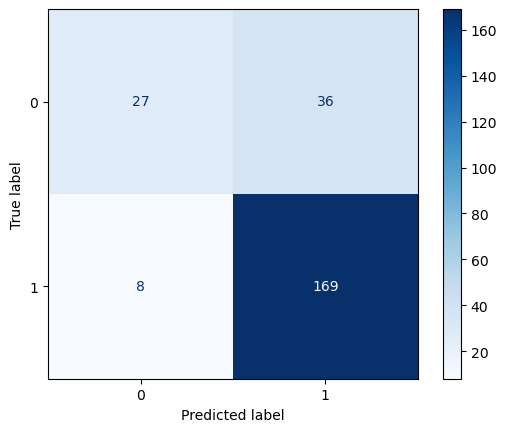

In [259]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Menilai model pada data uji (Xtest)
best_model = grid_search.best_estimator_
ytest_pred = best_model.predict(Xtest)

# Menghitung F1 Score pada data uji
test_f1 = f1_score(ytest, ytest_pred, average='weighted')
print(f"Test F1 Score: {test_f1:.4f}")

# Menghitung Confusion Matrix
cm = confusion_matrix(ytest, ytest_pred)

# Menampilkan Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
cm_display.plot(cmap='Blues')

### Feature Importance

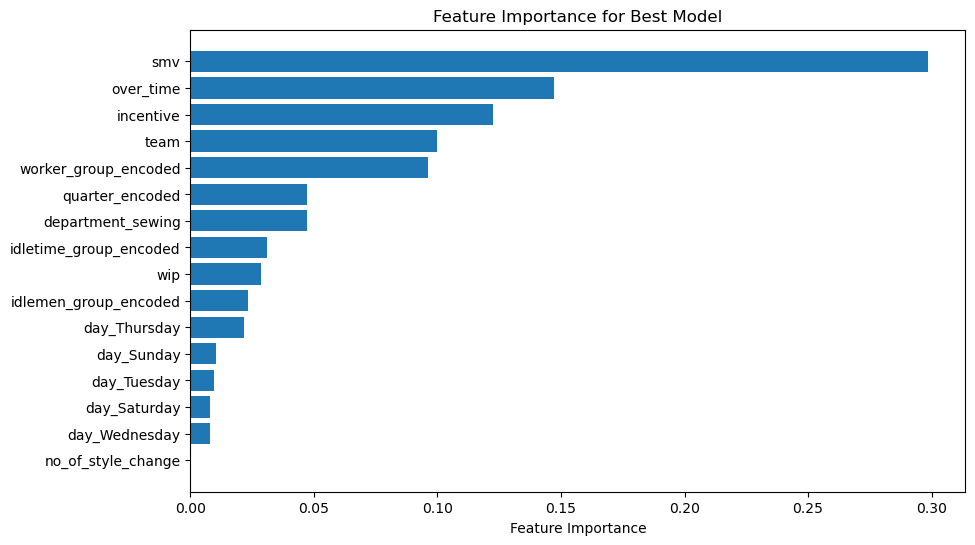

In [260]:
import matplotlib.pyplot as plt
import pandas as pd

# Mengambil model terbaik setelah grid search
best_model = grid_search.best_estimator_

# Mendapatkan feature importance
feature_importance = best_model.feature_importances_

# Mengurutkan fitur berdasarkan pentingnya
sorted_idx = feature_importance.argsort()[::-1]

# Membuat DataFrame untuk visualisasi
feature_names = Xtrain.columns
importance_df = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Importance': feature_importance[sorted_idx]
})

# Menampilkan feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Best Model')
plt.gca().invert_yaxis()  # Membalikkan urutan agar fitur terpenting di atas
plt.show()
